In [1]:
# import every libraries or modules
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
# data pipeline and hyper-parameters
data = load_iris()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]
trainX, testX = data.data[:100,1:3], data.data[100:,1:3]
trainY, testY = data.target[:100], data.target[100:]
weight = np.random.rand(trainX.shape[1])
lr = 0.001
iterations = 10000

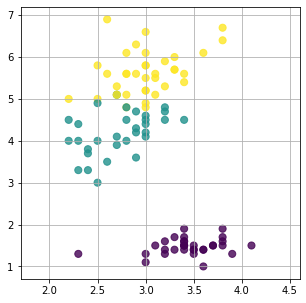

In [3]:
# quick insight to data
plt.figure(figsize=(5,5))
plt.scatter(x=trainX[:,0], y=trainX[:,1], s=50, alpha=0.8, c=trainY)
plt.xlim(trainX[:,0].min() - 0.5, trainX[:,0].max() + 0.5)
plt.grid()
plt.show()

In [4]:
# cost funtion
def mean_squared_error():
    global testX, testY
    
    predictY = np.dot(testX, weight)
    loss = np.mean((predictY - testY)**2)
    
    print(f"cost: {loss:.3f}")
# MSE

def mean_absolute_error():
    global testX, testY

    predictY = np.dot(testX, weight)
    loss = np.mean(abs(predictY - testY))
    
    print(f"cost: {loss:.3f}")
# MAE

In [5]:
# errors
mean_squared_error()
mean_absolute_error()

cost: 11.258
cost: 3.221


In [6]:
# define activation functions
nothing = lambda x: x
sigmoid = lambda x: 1 / (1 + 2.7182**(-x))  # don't use th!s

# activation fn dictionary
actDict = {"nothing":nothing,"sigmoid":sigmoid}

In [7]:
# define gradient descent rule
def gradient_descent_rule(name):
    global trainX, trainY, weight, lr
    
    activHX = actDict[name](np.dot(trainX, weight))
    weight -= (lr / trainX.shape[0]) * np.dot(trainX.T, (activHX - trainY))

In [8]:
# learning
for epoch in range(iterations):
    gradient_descent_rule("nothing")

In [9]:
# define predict
def predict(case):
    global weight
    
    if type(case) == list:
        case = np.array(case)
    
    return round(np.dot(case, weight))

In [10]:
# prediction of the model
index = random.randrange(len(testY))
prediction = predict(testX[index,:])
print(f"pred: {prediction:.3f}, actual target: {testY[index]}")

pred: 0.000, actual target: 0


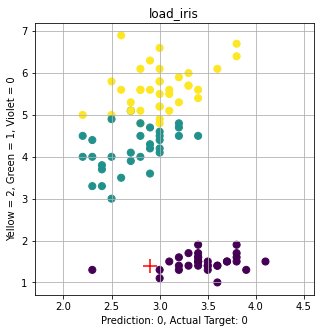

In [11]:
# plot everything we got
plt.figure(figsize=(5,5))
plt.scatter(x=trainX[:,0], y=trainX[:,1], s=50, alpha=1, c=trainY)
plt.scatter(x=testX[index,0], y=testX[index,1], c='r', s=200, marker='+')
plt.xlim(trainX[:,0].min() - 0.5, trainX[:,0].max() + 0.5)
plt.grid()
plt.xlabel(f"Prediction: {prediction:.0f}, Actual Target: {testY[index]}")
plt.ylabel("Yellow = 2, Green = 1, Violet = 0")
plt.title("load_iris")
plt.show()

In [12]:
# errors
mean_squared_error()
mean_absolute_error()

cost: 0.080
cost: 0.234
